<a href="https://colab.research.google.com/github/talhaanwarch/wound-segmentation/blob/master/FUSC_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#download data
!git clone https://github.com/talhaanwarch/wound-segmentation.git

fatal: destination path 'wound-segmentation' already exists and is not an empty directory.


In [2]:
%%capture
#install packages
!pip install tensorflow-gpu==2.1.0
!pip install -U segmentation-models
!!pip install -U albumentations

In [3]:
#import packages
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from tensorflow import keras
import numpy as np

Text(0.5, 1.0, 'Mask')

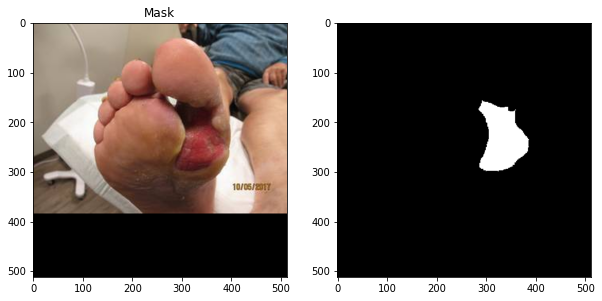

In [4]:
#explore data
image = Image.open('/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/0011.png')
mask=   Image.open('/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/0011.png')
fig,ax=plt.subplots(1,2,figsize=(10,15))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[0].set_title('Mask')

In [5]:
#get path of images and mask directories
train_image_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images/'
train_mask_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels/'

val_image_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/'
val_mask_path='/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/'

In [6]:
#load paths of images and masks files
train_input_img_paths=[i for i in glob(train_image_path+'*.png')]
train_target_img_paths =[i for i in glob(train_mask_path+'*.png')]

val_input_img_paths=[i for i in glob(val_image_path+'*.png')]
val_target_img_paths =[i for i in glob(val_mask_path+'*.png')]
print(len(train_input_img_paths),len(val_input_img_paths))

610 200


In [7]:
#create a data loader 
#credit: https://keras.io/examples/vision/oxford_pets_image_segmentation/
class DataLoader(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size,aug, preprocessing, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.preprocessing = preprocessing
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.augmentation=aug

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x,y =[], []
        for img_path,mask_path in zip(batch_input_img_paths,batch_target_img_paths):
            image,mask = Image.open(img_path),Image.open(mask_path).convert('L')
            image,mask = image.resize(img_size),mask.resize(img_size)
            if self.augmentation:
              sample = self.augmentation(image=np.array(image), mask=np.array(mask))
              image, mask = sample['image'], sample['mask']
            if self.preprocessing:
              sample = self.preprocessing(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']
            x.append(np.array(image))
            y.append(np.expand_dims(np.array(mask)/255, 2))
          
        return np.array(x), np.array(y)


In [8]:
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
img_size=(512, 512)
epochs=50
batch_size=12

Segmentation Models: using `tf.keras` framework.


In [9]:
import albumentations as A
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)]
    return A.Compose(train_transform)
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.HorizontalFlip(p=0),
        A.VerticalFlip(p=0)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [10]:
#load data to data loader in batch
train_gen = DataLoader(batch_size, img_size,get_training_augmentation(), get_preprocessing(preprocess_input), train_input_img_paths, train_target_img_paths)
val_gen = DataLoader(batch_size, img_size,get_validation_augmentation(),  get_preprocessing(preprocess_input), val_input_img_paths, val_target_img_paths)

In [11]:
#compile the model
metrics=[sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5),
                       sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5)
                       ]
model.compile('Adam',loss=sm.losses.bce_jaccard_loss,metrics=metrics
              )

In [12]:
#train the model
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 16 steps
Epoch 1/50
50/50 [==============================] - 58s 1s/step - loss: 1.0877 - iou_score: 0.3540 - f1-score: 0.4993 - precision: 0.4213 - recall: 0.6805 - val_loss: 175.5614 - val_iou_score: 0.0120 - val_f1-score: 0.0237 - val_precision: 0.0120 - val_recall: 0.9999
Epoch 2/50
50/50 [==============================] - 48s 967ms/step - loss: 0.6787 - iou_score: 0.5168 - f1-score: 0.6751 - precision: 0.6365 - recall: 0.7804 - val_loss: 946.6821 - val_iou_score: 0.0123 - val_f1-score: 0.0243 - val_precision: 0.0123 - val_recall: 1.0000
Epoch 3/50
50/50 [==============================] - 49s 979ms/step - loss: 0.5019 - iou_score: 0.5713 - f1-score: 0.7212 - precision: 0.7464 - recall: 0.7478 - val_loss: 14.3612 - val_iou_score: 0.0161 - val_f1-score: 0.0316 - val_precision: 0.0161 - val_recall: 0.9883
Epoch 4/50
50/50 [==============================] - 49s 990ms/step - loss: 0.4304 - iou_score: 0.61

In [13]:
scores = model.evaluate_generator(val_gen)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Loss: 0.27375
mean iou_score: 0.7497
mean f1-score: 0.85155
mean precision: 0.89387
mean recall: 0.82682


In [14]:
#get random image from val data and display the result
import random
test_img_number = random.randint(0, len(val_input_img_paths))
test_img = val_input_img_paths[test_img_number]
ground_truth=val_target_img_paths[test_img_number]
print(test_img)
print(ground_truth)

/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/images/0603.png
/content/wound-segmentation/data/Foot Ulcer Segmentation Challenge/validation/labels/0603.png


In [15]:
#resize image to be accepted by unet
test_img = Image.open(test_img)
test_img_resize =  test_img.resize(img_size)
print(test_img.size)
ground_truth = Image.open(ground_truth)

(512, 512)


(512, 512, 1)


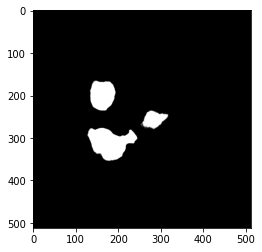

In [16]:
#Predict the output mask
test_img_input=np.expand_dims(test_img_resize, 0)
prediction = model.predict(test_img_input)[0,:,:,:]
print(prediction.shape)
plt.imshow(prediction.squeeze(),cmap='gray')

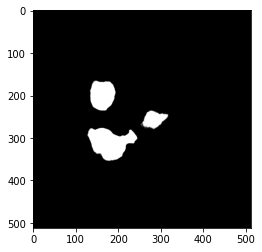

In [17]:
#resize image
from skimage.transform import resize
pred_resize=resize(prediction,(test_img.size[1],test_img.size[0]))
plt.imshow(pred_resize.squeeze(),cmap='gray')

Text(0.5, 1.0, 'Predicted Mask')

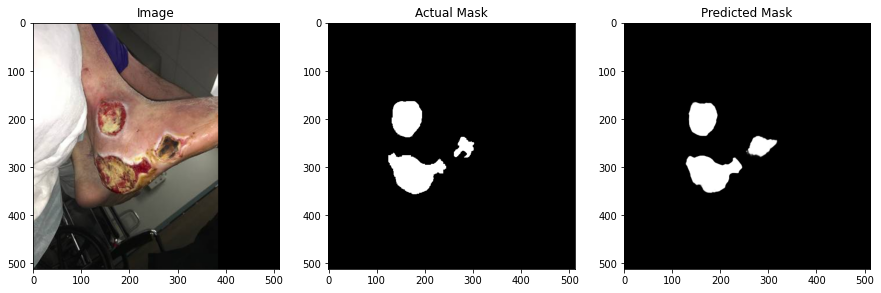

In [18]:
#display results
fig,ax=plt.subplots(1,3,figsize=(15,25))
ax[0].imshow(test_img)
ax[0].set_title('Image')
ax[1].imshow(ground_truth)
ax[1].set_title('Actual Mask')
ax[2].imshow(pred_resize.squeeze(),cmap='gray')
ax[2].set_title('Predicted Mask')